DeePyMoD ODE Example

In [2]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
import pandas as pd
import tensorflow as tf

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod.model.library import Library
import libraryODE

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series from .mat file and transform it into a Dataset object.

### Simulated with miaSim

Interaction matrix 
$A = \begin{pmatrix}
-0.5 & 30 & 0 & 0\\
-15 & -0.5 & 0 | 3 & 0 \\
0 & 0 & -0.5 & 20\\
0 & 0 & -10 & -0.5
\end{pmatrix}$

and growth rates:
$ b = (2/3, -1, 0.7, -3)$

Specify the number of species n_species and the number of timepoints n_samples in the given dataset:

In [3]:
# n_samples = None
# n_species = None

n_samples = 500
n_species = 4

# path of data file
filename = f"miaSim_GLV_{n_species}species_oscillating_zero.mat"
# filename = f"miaSim_GLV_{n_species}species_oscillating_three.mat"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/01e-timeseries-miaSim/" + filename

# data should be of the form:
# [n_samples, (1 + n_species)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 2

In [4]:
def create_data():
  data = loadmat(filepath)
  usol = np.real(data["ts_glv"]).astype("float32")
  usol = usol.reshape((n_samples, (1 + n_species)))
  ts = usol[:, 0]
  data_y = usol[:, 1:(1 + n_species)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [5]:
data = create_data()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 4])
Time: tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])
Data: tensor([[0.3637, 0.2098, 0.7249, 0.2187],
        [0.2101, 0.0100, 0.4347, 0.2902],
        [0.1181, 0.0102, 0.3007, 1.1348],
        [0.0926, 0.0152, 0.0631, 1.0253],
        [0.0926, 0.0197, 0.0601, 0.6114],
        [0.1093, 0.0225, 0.1263, 0.5382],
        [0.1438, 0.0271, 0.1497, 0.7521],
        [0.1950, 0.0448, 0.1029, 0.7494],
        [0.2167, 0.1136, 0.1080, 0.6549],
        [0.1307, 0.1957, 0.1262, 0.6786]])


Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [6]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

In [40]:
dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 500},
    preprocess_kwargs={
        "noise_level": 0.01,
        "normalize_coords": False,
        "normalize_data": False,
    },
    apply_normalize=custom_normalize,
    device=device
)

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 4])
Dataset is using device:  cpu


In [10]:
dataset = Dataset(
    create_data,
    device = device,
)

The coodinates have shape torch.Size([500, 1])
The data has shape torch.Size([500, 4])
Dataset is using device:  cpu


Visualization of the dataset

In [39]:
dataset.data.shape

torch.Size([500, 4])

Text(0.5, 1.0, 'Sampled and standardized data')

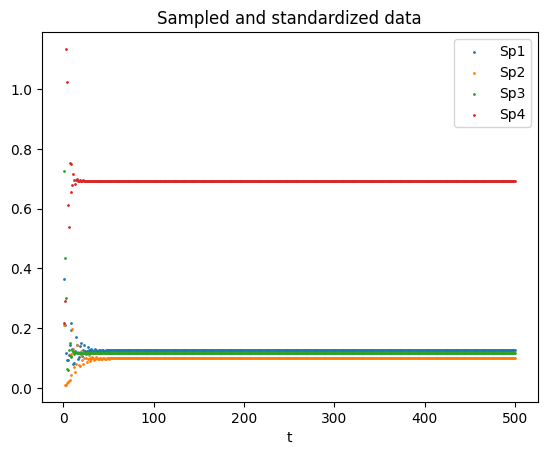

In [42]:
fig, ax = plt.subplots()
for i in np.arange(n_species):
    # plt.plot(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}")
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("Sampled and standardized data")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [22]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [25]:
network = NN(1, [30, 30, 30, 30], n_species)

Configuration of the library function.

In [35]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [36]:
library.get_content(dataset.data)

[['x1*1',
  'x1*x1',
  'x1*x2',
  'x1*x3',
  'x1*x4',
  'x1*x1*x1',
  'x1*x1*x2',
  'x1*x1*x3',
  'x1*x1*x4',
  'x1*x2*x2',
  'x1*x2*x3',
  'x1*x2*x4',
  'x1*x3*x3',
  'x1*x3*x4',
  'x1*x4*x4'],
 ['x2*1',
  'x2*x1',
  'x2*x2',
  'x2*x3',
  'x2*x4',
  'x2*x1*x1',
  'x2*x1*x2',
  'x2*x1*x3',
  'x2*x1*x4',
  'x2*x2*x2',
  'x2*x2*x3',
  'x2*x2*x4',
  'x2*x3*x3',
  'x2*x3*x4',
  'x2*x4*x4'],
 ['x3*1',
  'x3*x1',
  'x3*x2',
  'x3*x3',
  'x3*x4',
  'x3*x1*x1',
  'x3*x1*x2',
  'x3*x1*x3',
  'x3*x1*x4',
  'x3*x2*x2',
  'x3*x2*x3',
  'x3*x2*x4',
  'x3*x3*x3',
  'x3*x3*x4',
  'x3*x4*x4'],
 ['x4*1',
  'x4*x1',
  'x4*x2',
  'x4*x3',
  'x4*x4',
  'x4*x1*x1',
  'x4*x1*x2',
  'x4*x1*x3',
  'x4*x1*x4',
  'x4*x2*x2',
  'x4*x2*x3',
  'x4*x2*x4',
  'x4*x3*x3',
  'x4*x3*x4',
  'x4*x4*x4']]

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [ ]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [ ]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [ ]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [ ]:
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_S4/",
    max_iterations=100000,
    delta=1e-3,
    patience=100,
)

Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [ ]:
model.sparsity_masks

And it found the following coefficients.

In [ ]:
model.estimator_coeffs()

## Analysis/Visualization of the train() loss

In [ ]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [ ]:
# get list of all output values that were calculated during train()
# os.listdir("/data/deepymod/ODE_S4/")

In [ ]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

In [ ]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [ ]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [ ]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
# ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
# ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.legend()
# plt.xlim([0, 500])